# Features auf Bildern
skimage tutorial: http://www.scipy-lectures.org/packages/scikit-image/#input-output-data-types-and-colorspaces

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import skimage
#from skimage import io,img_as_float
from skimage import io, exposure,img_as_float
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['image.cmap'] = 'gray'


%matplotlib inline

skimage.__version__

'0.13.0'

## Rohdaten laden und anzeigen

(50, 50)


array([[133, 134, 134, ..., 137, 136, 136],
       [134, 133, 133, ..., 136, 136, 136],
       [134, 134, 134, ..., 136, 136, 136],
       ..., 
       [131, 130, 130, ..., 133, 134, 134],
       [131, 130, 130, ..., 133, 133, 133],
       [131, 130, 130, ..., 132, 133, 133]], dtype=uint8)

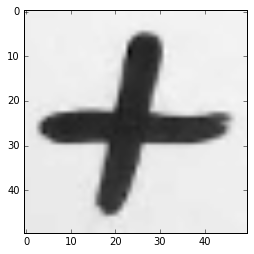

In [2]:
image = io.imread('data/p-01-BT-FFHS_Dozent.png')

print(image.shape)
plt.imshow(image,cmap='gray')
image

In [3]:
im = img_as_float(image)
np.min(im),np.max(im)

(0.050980392156862744, 0.55686274509803924)

## Grauwerthistogramme und kumulative Histogramme

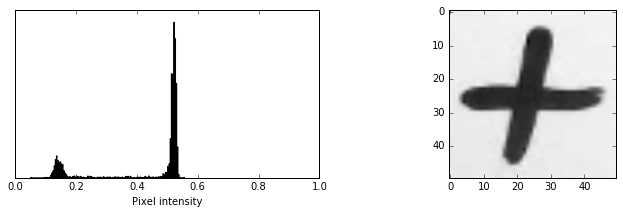

In [4]:
fig = plt.figure(figsize=(12,3));
ax_hist = plt.subplot(1,2,1);
bins=256
ax_hist.hist(im.ravel(), bins=bins, histtype='step', color='black')
ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax_hist.set_xlabel('Pixel intensity'),ax_hist.set_xlim(0, 1),ax_hist.set_yticks([])
ax_im = plt.subplot(1,2,2);
ax_im.imshow(im)
plt.show()

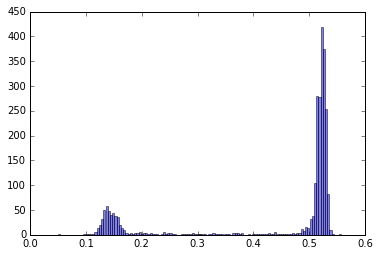

In [5]:
#exposure.histogram?
h,binc=exposure.histogram(im,nbins=256)
#plt.plot(binc,h)
plt.bar(binc, h, width=1/256.0,align='center', alpha=0.5);

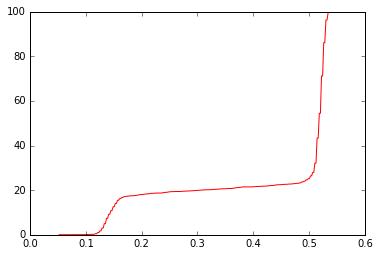

In [6]:
def remove_ticks(x=True,y=True):
    if x: plt.gca().axes.get_xaxis().set_visible(False)
    if y: plt.gca().axes.get_yaxis().set_visible(False)
        
# Kumulatives Histogramm
def plot_cumhist(image,bins=256,show_ticks=True,**kwargs):
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    plt.plot(bins, 100*img_cdf, 'r',**kwargs);
    
    #Zeige keine x- und y-Tickmarken
    if not show_ticks:
        remove_ticks()
    return img_cdf,bins
img_cdf,bins=plot_cumhist(im)

Es lohnt sich, obiges Bild gut zu studieren!  
- Was bedeutet die Steigung dieser Kurve?
- Was bedeutet die x-Achse?
- Was bedeutet die y-Achse?
- Quantile lassen sich gut ablesen! Wie?

In [7]:
p2 = np.percentile(im, 10)
p98 = np.percentile(im, 98)
p2,p98

(0.14509803921568629, 0.53333333333333333)

In [8]:
#Erst in zweiter Lesung wichtig: Diese Zeilen konstruieren perc_unstable für die 
#nächste Frage:
binNr = np.argmax(bins>0.3)
perc_unstable = int(round(img_cdf[binNr]*100))
perc_unstable

20

In [9]:
#offenbar weicht das 19%-Perzentil ziemlich stark vom 20%- oder 21%-Perzentil ab. Warum?
np.percentile(im, perc_unstable-1),np.percentile(im, perc_unstable),np.percentile(im, perc_unstable+1)

(0.24313725490196078, 0.30901960784313731, 0.36862745098039218)

In [10]:
#offenbar weicht das 40%-Perzentil kaum vom 65%- oder 90%-Perzentil ab. Warum?
np.percentile(im, 40),np.percentile(im, 65),np.percentile(im, 90)

(0.51372549019607838, 0.52156862745098043, 0.52941176470588236)

### Mittelwert vs. Median, Standardabweichung vs. Interquartilabstand

Vergleichen Sie die folgenden zwei Datensätze. Welche Unterschiede Stellen Sie bei den von der Series().describe() - Methode ausgegebenen deskriptiven Massen fest? Woran liegt das?

In [11]:
x1 = pd.Series(np.random.randn(1000))
x2 = pd.Series(list(x1)+[100.3,2301])

(0.0, 1.0)

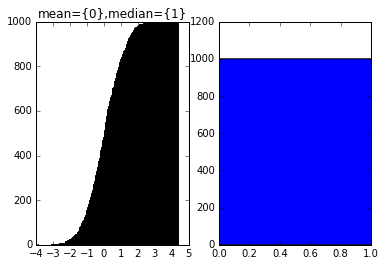

In [12]:
fig,axes=plt.subplots(1,2)
axes[0].hist(x1,cumulative=True,bins=200);axes[0].set_title('mean={0},median={1}')
xlim1=plt.xlim()
axes[1].hist(x2,cumulative=True,bins=200);
plt.xlim(xlim1)

In [13]:
x1.describe().round(2)

count    1000.00
mean        0.01
std         1.01
min        -3.90
25%        -0.65
50%         0.01
75%         0.71
max         4.39
dtype: float64

In [14]:
x2.describe().round(2)

count    1002.00
mean        2.41
std        72.76
min        -3.90
25%        -0.65
50%         0.01
75%         0.71
max      2301.00
dtype: float64

In obiger Statistik für x2 fehlt ein Mass, das auch für die Standardabweichung (std) ein Wert in der Nähe von 1 ergibt und die Breite der Verteilung beschreibt. Welches wäre das?

# Kontrastverstärkung

Sie haben bei der Erstellung des kollaborativen Kreuz-Kreis-Plus-Datensatzes einen Schwellwert wählen müssen, um Ihre Bilder zu binarisieren. Wie würden Sie diesen Schwellwert automatisiert wählen? Dazu sind Quantile nützlich, wie hier demonstriert wird.

(0.0, 1.0)

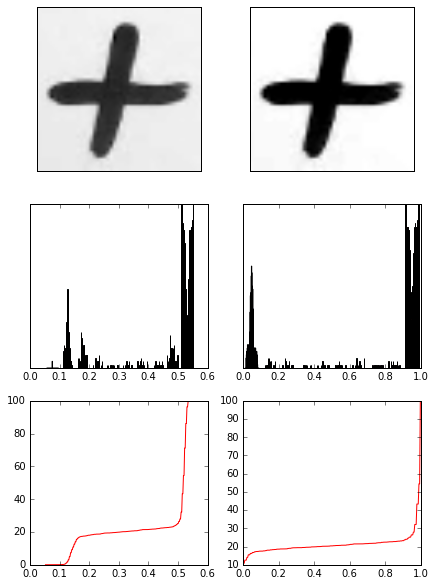

In [15]:
# Contrast stretching
p10 = np.percentile(im, 10)
p60 = np.percentile(im, 60)
fig = plt.figure(figsize=(7,10))
im_rescale = exposure.rescale_intensity(im, in_range=(p10, p60))
plt.subplot(3,2,1),plt.imshow(im);remove_ticks()
plt.subplot(3,2,2),plt.imshow(im_rescale);remove_ticks()
plt.subplot(3,2,3),plt.hist(im);remove_ticks(x=False)
plt.subplot(3,2,4),plt.hist(im_rescale);remove_ticks(x=False)
plt.subplot(3,2,5),plot_cumhist(im,show_ticks=True)
plt.subplot(3,2,6),plot_cumhist(im_rescale,show_ticks=True)

np.min(im_rescale),np.max(im_rescale)

Allerdings gibt es für dieses Problem auch andere, kompliziertere Methoden:

In [16]:
import skimage.filters
np.set_printoptions(precision=2)
np.array([
skimage.filters.threshold_li(im),\
skimage.filters.threshold_mean(im)])

array([ 0.29,  0.44])

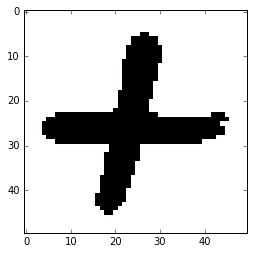

In [17]:
#Erzeuge ein binäres Bild mit einem der obigen Schwellwerte:
threshold=skimage.filters.threshold_li(im)
im_bin=np.where(im>threshold,1,0)
plt.imshow(im_bin,interpolation='none');

In [81]:
threshold_p=skimage.filters.threshold_li(image_p)
im_bin_p = np.where(image_p>threshold_p,0,1)

threshold_x=skimage.filters.threshold_li(image_x)
im_bin_x = np.where(image_x>threshold_x,0,1)

threshold_o=skimage.filters.threshold_li(image_o)
im_bin_o = np.where(image_o>threshold_o,0,1)

# Weitere Features

Die folgenden Zellen geben Ihnen Beispiele aus skimage, welche nützliche Bildfeatures extrahieren können.  
** Aufgabe **
- Versuchen Sie, diese Transformationen, also ihre Wirkung auf ein beliebiges Bild, zu verstehen.
- Recherchieren Sie auf http://scikit-image.org/docs/dev/api/skimage.transform.html weitere möglicherweise nützliche Transformationen
- Vergleichen Sie deren Wirkung auf Bilder der Klassen "+", "o" und "x"
- Finden Sie eine Transformation, welche die Klassifikation der Bilder in "+", "o" und "x" anschliessen so einfach wie möglich macht. Welche Featuretransformation schlagen Sie vor?
- Erstellen sie für einige Trainigsbilder aus jeder Klasse diese Bildtransformation und zeigen Sie diese Transformationen mit Hilfe der compare_images Funktion
- Reduzieren Sie (wenn möglich mit einem einfachen Schwellwertklassifikator) diese transformierten Bilder auf ein Klassenlabel. 
- Welche Erkennungsrate erreichen Sie? Geben Sie die Confusion-Matrix an.

## Gaussian blurring

In [82]:
from skimage.filters import sobel
from skimage import data 
from skimage.filters.rank import median
from skimage.filters import gaussian
from skimage.morphology import rectangle

In [83]:
def compare_images(imglist,figsize=(15,15),**kwargs):
    """
    Erstelle aus einer Liste von Pixel-Arrays eine Visualisierung 
    der dazugehörigen Bilder, für den praktischen visuellen Vergleich.
    """
    nImages=len(imglist)
    plt.figure(figsize=figsize)
    for i,image in enumerate(imglist):
        plt.subplot(1,nImages,i+1)
        plt.imshow(image,**kwargs);remove_ticks()

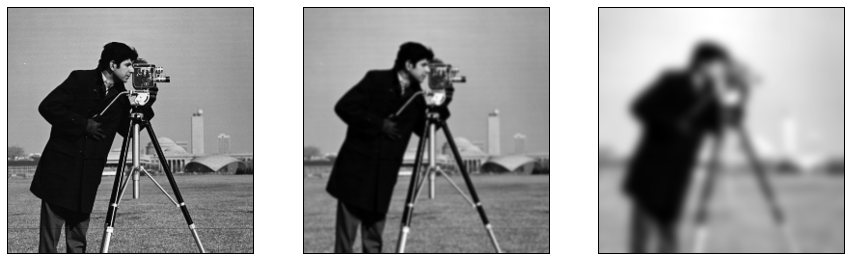

In [84]:
img_camera = img_as_float(data.camera())

from skimage.filters import gaussian
img2 = gaussian(img_camera,sigma=2)
img3 = gaussian(img_camera,sigma=10)
compare_images([img_camera,img2,img3])

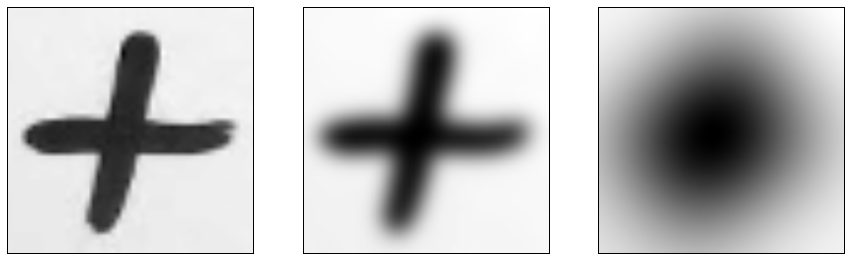

In [85]:
from skimage.filters import gaussian
img2 = gaussian(image,sigma=2)
img3 = gaussian(image,sigma=10)
compare_images([image,img2,img3])

## Sobel Kantendetektion

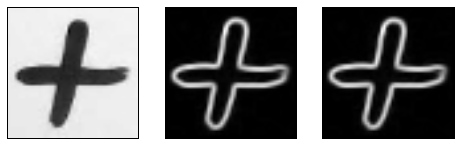

In [86]:
from skimage.filters import sobel
img2 = sobel(image)
img3 = sobel(image)
compare_images([image,img2,img3],figsize=(8,8))

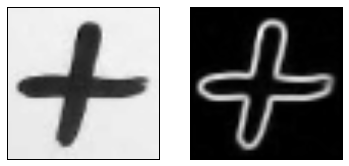

In [87]:
from skimage.morphology import rectangle
img2 = sobel(image)
compare_images([image,img2],figsize=(6,6))

## Histogram Equalization (?)

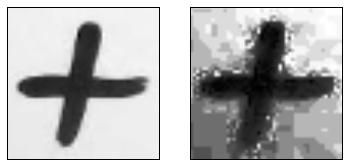

In [88]:
img_eq = exposure.equalize_hist(image)
compare_images([im,img_eq],figsize=(6,6))

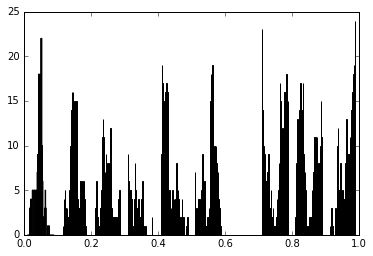

In [89]:
#Was da wohl passiert...?
plt.hist(img_eq);

## Konvolution mit einer Maske

Wir filtern hier das Bild mit einer Maske, welche eine gewünschte Struktur (hier horizontale oder vertikale Linien) bevorzugt.

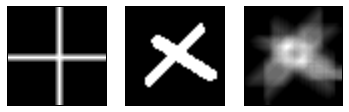

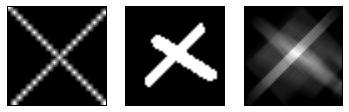

In [101]:
im_bin=im_bin_x
#Convolution mit einer Maske

from scipy import ndimage
#ndimage.convolve?

ap = np.zeros((20,20), dtype=np.int)
ap[10, :] = 1
ap[:,10] = 1
compare_images([ap,im_bin,
ndimage.convolve(im_bin,ap, mode='mirror', cval=0.0)],figsize=(6,6))

ax = np.zeros((20,20), dtype=np.int)
ax[np.arange(20),np.arange(20)] = 1
ax[(20-np.arange(20))%20,np.arange(20)] = 1
compare_images([ax,im_bin,
ndimage.convolve(im_bin,ax, mode='mirror', cval=0.0)],figsize=(6,6))

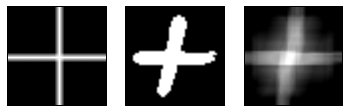

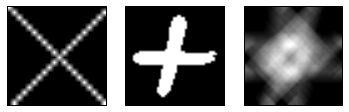

In [102]:
im_bin=im_bin_p
#Convolution mit einer Maske

from scipy import ndimage
#ndimage.convolve?

ap = np.zeros((20,20), dtype=np.int)
ap[10, :] = 1
ap[:,10] = 1
compare_images([ap,im_bin,
ndimage.convolve(im_bin,ap, mode='mirror', cval=0.0)],figsize=(6,6))

ax = np.zeros((20,20), dtype=np.int)
ax[np.arange(20),np.arange(20)] = 1
ax[(20-np.arange(20))%20,np.arange(20)] = 1
compare_images([ax,im_bin,
ndimage.convolve(im_bin,ax, mode='mirror', cval=0.0)],figsize=(6,6))

## Skeletonization
Damit werden Linien bis auf die Dicke eines Pixels ausgedünnt. Dabei werden keine zusammenhängende Linien in zwei Stücke zerbrochen werden.

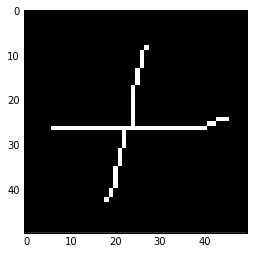

In [33]:
#plt.imshow(skimage.morphology.skeletonize(im_bin))#??? Falsch rum!
im_skeleton=skimage.morphology.skeletonize(1-im_bin)
plt.imshow(im_skeleton,interpolation='none')

In [34]:
skimage.transform.hough_line()

TypeError: hough_line() missing 1 required positional argument: 'img'

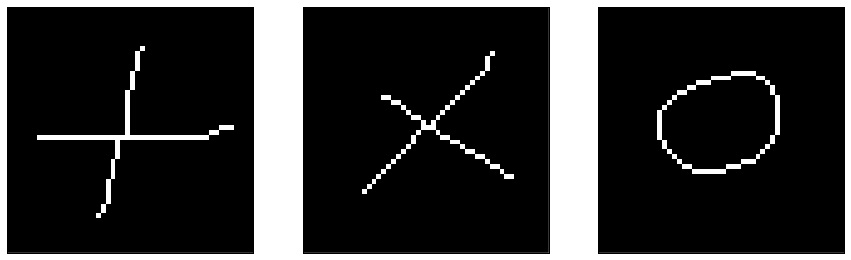

In [41]:
im_skeleton_p=skimage.morphology.skeletonize(im_bin_p)
im_skeleton_x=skimage.morphology.skeletonize(im_bin_x)
im_skeleton_o=skimage.morphology.skeletonize(im_bin_o)
compare_images([im_skeleton_p,im_skeleton_x,im_skeleton_o],interpolation='none')

## Hough-Transformation

Siehe http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html

Die Hough-Transformation ist geeignet, um gerade Linien in beliebiger Lage zu entdecken. Ein Nachteil ist, dass die Berechnung Rechenintensiv ist, und je nach Komplexität des Bildes/Hintergrunds diese Linien schlecht gefunden werden.

In [42]:
#skimage.transform.hough_line?
hspace,angles,distances=skimage.transform.hough_line(im_bin)
hspace_skel,angles_skel,distances_skel=skimage.transform.hough_line(im_skeleton)

In [43]:
hspace.shape,angles.shape,distances.shape

((142, 180), (180,), (142,))

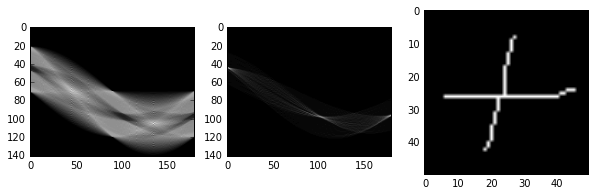

In [44]:
plt.figure(1,figsize=(10,18))
plt.subplot(1,3,1),plt.imshow(hspace)
plt.subplot(1,3,2),plt.imshow(hspace_skel);
plt.subplot(1,3,3),plt.imshow(im_skeleton);

In [45]:
#skimage.transform.hough_line_peaks?
accum_skel_2, angles_skel_2, dists_skel_2 =\
   skimage.transform.hough_line_peaks(hspace_skel,angles_skel,
                                      distances_skel)    

In [46]:
accum_skel_2

array([35, 27], dtype=uint64)

(0, 50)

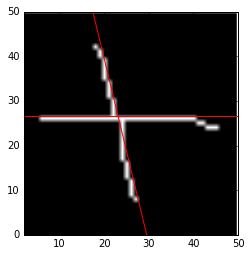

In [47]:
plt.imshow(im_skeleton)
for _, angle, dist in zip(accum_skel_2, angles_skel_2, dists_skel_2):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - im_skeleton.shape[1] * np.cos(angle)) / np.sin(angle)
    plt.plot((0, im_skeleton.shape[1]), (y0, y1), '-r')
plt.xlim(*angles_skel_2.shape)
plt.ylim(0,im_skeleton.shape[0])